In [4]:
from datetime import date, timedelta
from functools import partial
from time import sleep
from calendar import monthrange

import pandas as pd

from pytrends.exceptions import ResponseError
from pytrends.request import TrendReq


def get_last_date_of_month(year: int, month: int) -> date:
    """Given a year and a month returns an instance of the date class
    containing the last day of the corresponding month.
    Source: https://stackoverflow.com/questions/42950/get-last-day-of-the-month-in-python
    """
    return date(year, month, monthrange(year, month)[1])


def convert_dates_to_timeframe(start: date, stop: date) -> str:
    """Given two dates, returns a stringified version of the interval between
    the two dates which is used to retrieve data for a specific time frame
    from Google Trends.
    """
    return f"{start.strftime('%Y-%m-%d')} {stop.strftime('%Y-%m-%d')}"


def _fetch_data(pytrends, build_payload, timeframe: str) -> pd.DataFrame:
    """Attempts to fecth data and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            build_payload(timeframe=timeframe)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return pytrends.interest_over_time()


def get_daily_data(word: str,
                 start_year: int,
                 start_mon: int,
                 stop_year: int,
                 stop_mon: int,
                 geo: str = 'US',
                 verbose: bool = True,
                 wait_time: float = 5.0) -> pd.DataFrame:
    """Given a word, fetches daily search volume data from Google Trends and
    returns results in a pandas DataFrame.
    Details: Due to the way Google Trends scales and returns data, special
    care needs to be taken to make the daily data comparable over different
    months. To do that, we download daily data on a month by month basis,
    and also monthly data. The monthly data is downloaded in one go, so that
    the monthly values are comparable amongst themselves and can be used to
    scale the daily data. The daily data is scaled by multiplying the daily
    value by the monthly search volume divided by 100.
    For a more detailed explanation see http://bit.ly/trendsscaling
    Args:
        word (str): Word to fetch daily data for.
        start_year (int): the start year
        start_mon (int): start 1st day of the month
        stop_year (int): the end year
        stop_mon (int): end at the last day of the month
        geo (str): geolocation
        verbose (bool): If True, then prints the word and current time frame
            we are fecthing the data for.
    Returns:
        complete (pd.DataFrame): Contains 4 columns.
            The column named after the word argument contains the daily search
            volume already scaled and comparable through time.
            The column f'{word}_unscaled' is the original daily data fetched
            month by month, and it is not comparable across different months
            (but is comparable within a month).
            The column f'{word}_monthly' contains the original monthly data
            fetched at once. The values in this column have been backfilled
            so that there are no NaN present.
            The column 'scale' contains the scale used to obtain the scaled
            daily data.
    """

    # Set up start and stop dates
    start_date = date(start_year, start_mon, 1) 
    stop_date = get_last_date_of_month(stop_year, stop_mon)

    # Start pytrends for US region
    pytrends = TrendReq(hl='pt-BR', tz=180)
    # Initialize build_payload with the word we need data for
    build_payload = partial(pytrends.build_payload,
                            kw_list=[word], cat=0, geo=geo, gprop='')

    # Obtain monthly data for all months in years [start_year, stop_year]
    monthly = _fetch_data(pytrends, build_payload,
                         convert_dates_to_timeframe(start_date, stop_date))

    # Get daily data, month by month
    results = {}
    # if a timeout or too many requests error occur we need to adjust wait time
    current = start_date
    while current < stop_date:
        last_date_of_month = get_last_date_of_month(current.year, current.month)
        timeframe = convert_dates_to_timeframe(current, last_date_of_month)
        if verbose:
            print(f'{word}:{timeframe}')
        results[current] = _fetch_data(pytrends, build_payload, timeframe)
        current = last_date_of_month + timedelta(days=1)
        sleep(wait_time)  # don't go too fast or Google will send 429s

    daily = pd.concat(results.values()).drop(columns=['isPartial'])
    complete = daily.join(monthly, lsuffix='_unscaled', rsuffix='_monthly')

    # Scale daily data by monthly weights so the data is comparable
    complete[f'{word}_monthly'].ffill(inplace=True)  # fill NaN values
    complete['scale'] = complete[f'{word}_monthly'] / 100
    complete[word] = complete[f'{word}_unscaled'] * complete.scale

    return complete

In [6]:
df = get_daily_data(word= 'corrupção',
                 start_year= 2006,
                 start_mon= 1,
                 stop_year= 2006,
                 stop_mon= 12,
                 geo= 'BR',
                 verbose = True,
                 wait_time = 1.0 )

corrupção:2006-01-01 2006-01-31
corrupção:2006-02-01 2006-02-28
corrupção:2006-03-01 2006-03-31
corrupção:2006-04-01 2006-04-30
corrupção:2006-05-01 2006-05-31
corrupção:2006-06-01 2006-06-30
corrupção:2006-07-01 2006-07-31
corrupção:2006-08-01 2006-08-31
corrupção:2006-09-01 2006-09-30
corrupção:2006-10-01 2006-10-31
corrupção:2006-11-01 2006-11-30
corrupção:2006-12-01 2006-12-31


In [7]:
df.head()

,corrupção_unscaled,corrupção_monthly,isPartial,scale,corrupção
date,,,,,
2006-01-01,0,39.0,False,0.39,0.0
2006-01-02,0,39.0,NaN,0.39,0.0
2006-01-03,100,39.0,NaN,0.39,39.0
2006-01-04,0,39.0,NaN,0.39,0.0
2006-01-05,0,39.0,NaN,0.39,0.0


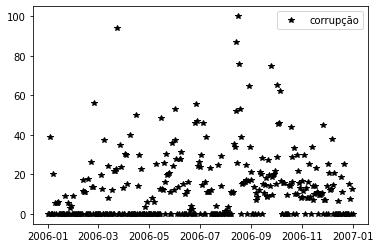

In [10]:
# import matplotlib plotting module to visualize data (make sure matplotlib is installed using pip)
import matplotlib.pyplot as plt

# plot the trend in chart
plt.figure()
plt.plot(df.index,df.corrupção,'k*')
plt.legend(['corrupção'])
#plt.savefig('plot2006.jpg')

,corrupção_unscaled,corrupção_monthly,isPartial,scale,corrupção
date,,,,,
2006-01-01,0,39.0,False,0.39,0.0
2006-01-02,0,39.0,NaN,0.39,0.0
2006-01-03,100,39.0,NaN,0.39,39.0
2006-01-04,0,39.0,NaN,0.39,0.0
2006-01-05,0,39.0,NaN,0.39,0.0
...,...,...,...,...,...
2006-12-22,0,32.0,NaN,0.32,0.0
2006-12-23,0,32.0,NaN,0.32,0.0
2006-12-24,0,19.0,False,0.19,0.0


In [11]:
df.to_csv('out.csv')